# MSDM5002 Assignment 5 

In [1]:
import pandas as pd
import numpy as np
import requests as req
import re
from io import StringIO
from bs4 import BeautifulSoup
from matplotlib import pyplot as plt
from matplotlib import style
from matplotlib.animation import FuncAnimation
import matplotlib.dates as mdates

datefmt = mdates.DateFormatter('%d/%m')
style.use("seaborn")
plt.rcParams["animation.html"] = "jshtml"

## 1. COVID in Hong Kong

### a. Plot the number of (confirmed) cases and its 7-day moving average

In [2]:
def download_save(url,save_at="data"):
    r = req.get(url)
    df = pd.read_csv(StringIO(r.text))
    name = url.split("/")[-1]
    df.to_csv(f"{save_at}/{name}")
    return df

In [3]:
df = download_save("http://www.chp.gov.hk/files/misc/latest_situation_of_reported_cases_covid_19_eng.csv")

In [4]:
dfa = pd.DataFrame({
    "Date":pd.to_datetime(df["As of date"],dayfirst=True),
    "Confirmed":df["Number of confirmed cases"],
    "NucleicAcid":df["Number of cases tested positive for SARS-CoV-2 virus by nucleic acid tests"],
    "RapidAntigen":df["Number of cases tested positive for SARS-CoV-2 virus by rapid antigen tests"]
})

dfa.NucleicAcid.fillna(0,inplace=True)
dfa.RapidAntigen.fillna(0,inplace=True)
dfa.Confirmed.fillna(dfa.NucleicAcid + dfa.RapidAntigen,inplace=True)
dfa["Daily"]=dfa.Confirmed.diff()
dfa["SMA7"] = dfa.Daily.rolling(7,center=True).mean()
dfa.drop(index=dfa.index[dfa.Date=="2020-02-29"],inplace=True)

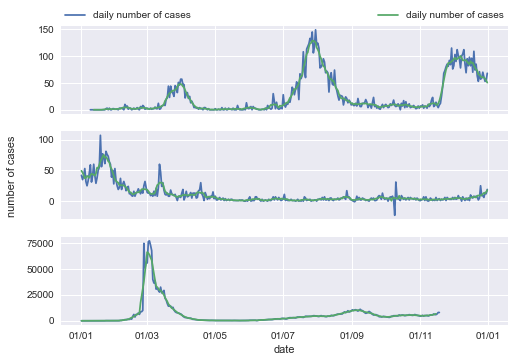

In [5]:
fig,axes = plt.subplots(3,1,sharex=True)
for i,ax in enumerate(axes):
    df_annual = dfa[dfa.Date.dt.year==(2020+i)]
    date = df_annual.Date.apply(lambda x: x.replace(year=1970))
    ax.xaxis.set_major_formatter(datefmt)
    ax.plot(date, df_annual.Daily,label="daily number of cases")
    ax.plot(date, df_annual.SMA7,label="daily number of cases")
    if i == 0:
        ax.legend(bbox_to_anchor=(0, 1.02, 1, 0.2), loc="lower left",
                mode="expand", borderaxespad=0, ncol=2)

fig.text(0.04, 0.5, 'number of cases', va='center', ha='center', rotation='vertical', fontsize=plt.rcParams['axes.labelsize'])
plt.xlabel("date")
plt.show()

### b. Boil them down into two large categories, viz. “local case” and “imported case”: 
a case is local if the name of its original type has the word “local(ly)”, otherwise it is imported. Plot 
the number of these two types of cases with a stacked chart

In [6]:
df = download_save("http://www.chp.gov.hk/files/misc/enhanced_sur_covid_19_eng.csv")

In [7]:
dfb = pd.DataFrame({
    "Date":pd.to_datetime(pd.to_datetime(df["Report date"],dayfirst=True)),
    "Classification":df["Classification*"]
})
Iidx = dfb.Classification.isin(["Imported case","Epidemiologically linked with imported case"])
dfbI = dfb[Iidx]
dfbL = dfb[~Iidx]

In [8]:
dfbIStats = pd.Series(0,index=dfb.Date.unique())
dfbIStats.update(dfbI.value_counts(subset="Date",sort=False))
dfbLStats = pd.Series(0,index=dfb.Date.unique())
dfbLStats.update(dfbL.value_counts(subset="Date",sort=False))

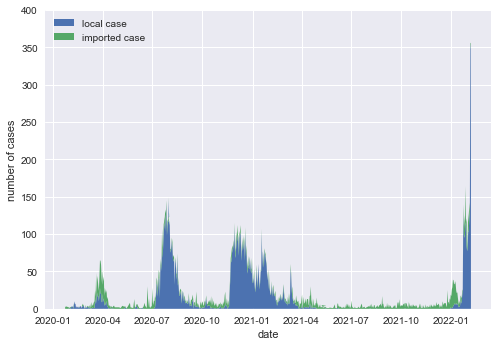

In [9]:
plt.stackplot(dfbLStats.index,dfbLStats.values,dfbIStats.values,labels=("local case","imported case"))
plt.xlabel("date")
plt.ylabel("number of cases")
plt.ylim([0,400])
plt.legend(loc="upper left")
plt.show()

### c. Using the same CSV file as (b), now consider three columns “Report date”, “Gender”, and “Age”. Plot the age and gender distribution of the cases with a bar chart. 
The patients’ ages are binned into tens. 

In [10]:
df.Age.replace("<1",0, inplace=True)
df.Age.replace("Pending",-1, inplace=True)
MAges = df[df.Gender == "M"].Age.values.astype(int)
FAges = df[df.Gender == "F"].Age.values.astype(int)

In [11]:
def age_dist(ages,N):
    dist = {}
    rate = len(ages)/N
    for lower in range(0,110,10):
        higher = lower + 9
        dist['100+' if higher >= 100 else f'{lower}-{higher}'] = 100*rate*np.mean((lower <= ages) * (ages <= higher))
    return dist

In [12]:
N=len(MAges)+len(FAges)
mdist = age_dist(MAges,N)
fdist = age_dist(FAges,N)

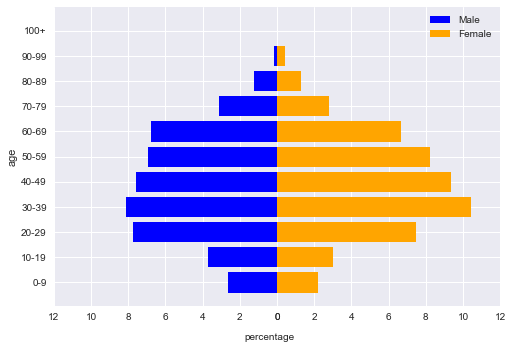

In [13]:
fig, axes = plt.subplots(1,2,sharey=True)
axes[0].barh(tuple(mdist.keys()),tuple(mdist.values()),color="blue",label="Male")
axes[0].set_xlim((0,12))
axes[0].invert_xaxis()
axes[0].set_ylabel("age")
axes[1].barh(tuple(mdist.keys()),0,color="blue",label="Male")
axes[1].barh(tuple(fdist.keys()),tuple(fdist.values()),color="orange",label="Female")
axes[1].set_xlim((0,12))
fig.text(0.5, 0.04, 'percentage', ha='center')
plt.subplots_adjust(wspace=0)
plt.legend()
plt.show()

## 2. Typhoons in Hong Kong
### a. Go to https://www.weather.gov.hk/en/informtc/historical_tc/metinfo_wind.htm. 
The first table records information of typhoons that required Signal No. 10 since 1946. Write a 
function typhoon_data() that gets the data with Beautiful Soup, puts them in a Pandas 
data frame, and returns the data frame. 

In [14]:
def typhoon_data():
    res = req.get("https://www.weather.gov.hk/en/informtc/historical_tc/metinfo_wind.htm")
    soup = BeautifulSoup(res.content)
    table_html = soup.find('table')
    return pd.read_html(str(table_html))[0]

In [15]:
typhoon_df = typhoon_data() 
typhoon_df

Name of typhoon Nearest approach to the  Hong Kong Observatory        \
   Name of typhoon                                     Date/Month  Year   
0                -                                           18/7  1946   
1           Gloria                                           22/9  1957   
2             Mary                                            9/6  1960   
3            Alice                                           19/5  1961   
4            Wanda                                            1/9  1962   
5             Ruby                                            5/9  1964   
6              Dot                                          13/10  1964   
7          Shirley                                           21/8  1968   
8             Rose                                           17/8  1971   
9            Elsie                                          14/10  1975   
10            Hope                                            2/8  1979   
11           Ellen                                            9/9  1983   
12            York                                           16/9  1999   
13         Vicente                                           24/7  2012   
14            Hato                                           23/8  2017   
15        Mangkhut                                           16/9  2018   

                            Minimum M.S.L.  pressure (hPa)         \
   Direction Distance  (km)                         Hourly  Inst.   
0          S             70                          985.7      -   
1         SW             55                          986.2  984.3   
2        WNW             10                          974.3  973.8   
3          -              0                          981.6  981.1   
4        SSW             20                          955.1  953.2   
5         SW             30                          971.0  968.2   
6          E             35                          978.9  977.3   
7          -              0                          968.7  968.6   
8        WSW             20                          984.5  982.8   
9          S             50                          996.4  996.2   
10       NNW             10                          961.8  961.6   
11        SW             45                          983.9  983.1   
12       SSW             20                          976.8  976.1   
13        SW            100                          986.3  986.0   
14       SSW             60                          986.7  986.3   
15       SSW            100                          977.6  977.0   

   Maximum intensity of the typhoon during the period of tropical cyclone warning signal no. 8 or above  \
                                                                                               Category   
0                                                   &                                                     
1                                            Severe T                                                     
2                                                   T                                                     
3                                                   T                                                     
4                                             Super T                                                     
5                                             Super T                                                     
6                                                   T                                                     
7                                                   T                                                     
8                                             Super T                                                     
9                                                   T                                                     
10                                            Super T                                                     
11                

### b. Hato (天鴿) and Mangkhut (山竹) are the two strongest typhoons in recent years. 
The  webpages  https://ibtracs.unca.edu/index.php?name=v04r00-2017232N19130  and 
https://ibtracs.unca.edu/index.php?name=v04r00-2018250N12170 record their paths. At 
the  bottom of  the  pages,  “HKO  LAT” and  “HKO  LON” represent  their  latitudes  and 
longitudes as measured by the Hong Kong Observatory. Get the data with Beautiful Soup, 
then create a GIF image or an MP4 video that plot their paths. 

In [16]:
def get_typhoon_df(url):
    res = req.get(url)
    soup = BeautifulSoup(res.content)
    h1 = soup.find("h1")
    name = re.findall("Typhoon ([A-Z]+)", h1.text)[0]
    table = soup.find_all("table")[-1]
    df = pd.read_html(str(table))[0]
    df = df.loc[:,["ISO_TIME_________","HKO LAT","HKO LON"]].rename(columns={"ISO_TIME_________": "ISO TIME"})
    df.drop(0,inplace=True)
    df.fillna(0,inplace=True)
    df["HKO LAT"]= pd.to_numeric(df["HKO LAT"])
    df["HKO LON"]= pd.to_numeric(df["HKO LON"])
    return name, df

In [17]:
urls = ("https://ibtracs.unca.edu/index.php?name=v04r00-2017232N19130",
"https://ibtracs.unca.edu/index.php?name=v04r00-2018250N12170")

typhoon_positions = {name:df for name,df in map(get_typhoon_df,urls)}

In [18]:
HKLAT,HKLON=22.3193,114.1694

In [19]:
def distance(lat1, lat2, lon1, lon2):
    """Calculate distance between two lats and lons"""
    lon1 = np.radians(lon1)
    lon2 = np.radians(lon2)
    lat1 = np.radians(lat1)
    lat2 = np.radians(lat2)
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat / 2)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2)**2
    c = 2 * np.arcsin(np.sqrt(a))
    r = 6371
    return(c * r)


def relative_hour(df):
    N = len(df)
    df["DISTANCE"] = distance(df["HKO LAT"],HKLAT,df["HKO LON"],HKLON)
    df["HOUR"] = pd.Series(3*np.arange(-1,N+1))
    closest_idx = df["DISTANCE"].argmin()
    closest_time = df.loc[closest_idx,"HOUR"]
    df["HOUR"] -= closest_time


In [20]:
for df in typhoon_positions.values():
    relative_hour(df)
df

,ISO TIME,HKO LAT,HKO LON,DISTANCE,HOUR
1,2018-09-06 12:00:00,0.0,0.0,12482.408682,-240
2,15:00:00,0.0,0.0,12482.408682,-237
3,18:00:00,0.0,0.0,12482.408682,-234
4,21:00:00,0.0,0.0,12482.408682,-231
5,2018-09-07 00:00:00,0.0,0.0,12482.408682,-228
...,...,...,...,...,...
95,06:00:00,23.7,107.3,719.549170,42
96,09:00:00,24.1,106.8,778.592227,45
97,12:00:00,0.0,0.0,12482.408682,48
98,15:00:00,0.0,0.0,12482.408682,51


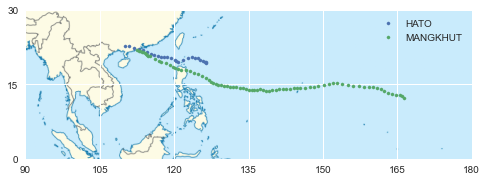

In [21]:
map = plt.imread("img/equirectangular_map.png")
ydeg2loc = lambda deg: map.shape[0]/180*(90-deg)
xdeg2loc = lambda deg: map.shape[1]/360*(deg+180)

fig = plt.figure()
ydegs = np.linspace(-90,90,13)[::-1].astype(int)
xdegs = np.linspace(-180,180,25).astype(int)

def eachframe(h):
    plt.cla()
    plt.imshow(map)
    plt.yticks(ydeg2loc(ydegs),ydegs)
    plt.xticks(xdeg2loc(xdegs),xdegs)
    plt.ylim(ydeg2loc(np.array([0,30])))
    plt.xlim(xdeg2loc(np.array([90,180])))
    for key, df in typhoon_positions.items():
        xs = df.loc[df["HOUR"] <= h,"HKO LON"].to_numpy()
        ys = df.loc[df["HOUR"] <= h,"HKO LAT"].to_numpy()
        plt.scatter(xdeg2loc(xs),ydeg2loc(ys),label=key,s=10)
    plt.legend()

anim = FuncAnimation(fig, eachframe,np.arange(-15,15+1,3),interval=300)
anim.save("img/2-b.gif")
anim